## Imports

In [1]:
import torch

import chess
import chess.engine
import chess.svg

from transformers import AutoTokenizer, TextGenerationPipeline, \
    GPT2LMHeadModel, GPT2Tokenizer, pipeline

from datasets import load_from_disk  # load_dataset

from copy import deepcopy
from typing import List, Dict, Optional, Any

from utils.chessplaying_utils import generate_answer, \
    run_single_game_eval, show_results_forced_test, \
    show_results_single_eval, run_legal_forced_test

import warnings
warnings.filterwarnings("ignore")

In [2]:
moves_data = "data/subset_games"
stockfish_path = (
    r"C:\Users\barte\Desktop\Studies\chess_bot\PikeBot"
    r"\engine\stockfish\stockfish-windows-x86-64-avx2.exe"
)
stockfish = chess.engine.SimpleEngine.popen_uci(stockfish_path)

In [3]:
WHITE = 0
BLACK = 1

## Data

In [4]:
# dataset = load_dataset("mlabonne/chessllm")

In [5]:
# subset = dataset["train"].select(range(1000))
# subset.save_to_disk("data/subset_games")

In [4]:
test_data_moves = load_from_disk(moves_data)
test_data_moves

Dataset({
    features: ['average_elo', 'transcript'],
    num_rows: 1000
})

In [5]:
test_data_moves['transcript'][:5]

['1. e4 e5 2. d4 d5 3. exd5 exd4 4. Qxd4 c5 5. Qe4+ Ne7 6. Bg5 f6 7. Nf3 fxg5 8. Nxg5 h6 9. Nh7 Bf5 10. Qe5 Bxh7 11. Nc3 Bxc2 12. Bb5+ Nd7 13. Bxd7+ Qxd7 14. O-O a6 15. Rfe1 b5 16. Ne4 c4 17. d6 Bxe4 18. dxe7 Bxe7 19. Qxe4 Qd2 20. Qxa8+ Kf7 21. Qxh8 Qxb2 22. Rad1 Bc5 23. Rd7+ Kg6 24. Qe8+ Kf5 25. Re4 Qxf2+ 26. Kh1 Qf1# 0-1',
 '1. e4 c5 2. Nf3 e6 3. d4 d5 4. exd5 exd5 5. Ne5 a6 6. Qh5 Nf6 7. Qxf7# 1-0',
 '1. d4 d5 2. Nc3 Bd7 3. e4 dxe4 4. Nxe4 Nc6 5. c3 a6 6. Qf3 g6 7. Bd3 Bg7 8. Ne2 Nf6 9. O-O Bg4 10. Nxf6+ Bxf6 11. Qxg4 O-O 12. Bh6 e5 13. Bxf8 Kxf8 14. Rad1 exd4 15. Nxd4 Nxd4 16. Bxg6 hxg6 17. cxd4 Kg7 18. f4 Qd6 19. f5 Rh8 20. g3 Qb6 21. fxg6 Qxb2 22. gxf7+ Kxf7 23. Qd7+ Kg6 24. Rxf6+ Kxf6 25. Rf1+ Kg6 26. Qf7+ Kh6 27. Rf6+ 1-0',
 '1. e4 Nc6 2. d3 Nd4 3. Nd2 Ne6 4. Ngf3 Nf4 5. g3 Ng6 6. Bg2 Nf6 7. O-O d6 8. Rfe1 Qd7 9. Nf1 Qg4 10. d4 Nxe4 11. Nf3d2 Qxd1 12. Rexd1 Ng5 13. Ne4 Ne6 14. Ng5 Nd8 15. Rde1 Bf5 16. Ne3 Bd7 17. a4 Bc6 18. b4 e6 19. b5 Bd7 20. c4 Be7 21. a5 Bxg5 22. a6 bxa6 23

## Model loading

In [8]:
device_name = torch.cuda.get_device_name(0)
print("Device 0:", device_name)

Device 0: NVIDIA GeForce RTX 3060 Ti


In [9]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
generator = pipeline("text-generation", model="gpt2", device=0)
generator("Once upon a time,", max_length=40, truncation=True,
          pad_token_id=generator.tokenizer.eos_token_id)

[{'generated_text': 'Once upon a time, everyone looked at the same black outline of the sun. This was where all of the other images in the scene came in. This was a common ground. Everyone agreed on the'}]

In [10]:
model_config = generator.model.config
print(f"""
{model_config.num_beams, model_config.num_beam_groups}
{model_config.do_sample}
{model_config.top_p, model_config.top_k}
{model_config.max_length, model_config.no_repeat_ngram_size}
{model_config.remove_invalid_values}
{model_config.num_return_sequences}
""")


(1, 1)
True
(1.0, 50)
(50, 0)
False
1



In [11]:
generate_answer(generator, "Once upon a time,", num_answers=2)

["Once upon a time, you know how to call. But on that very day, you know, at the very least, that's when it really takes the world a little bit out of whack",
 'Once upon a time, the first one to become proficient in one would take a step back. Only once, a third time, would the second ever be successfully achieved.\n\n"Your… training']

## Evaluation based on previous moves

#### Test 1: for a single situation analyse gpt answers

Using sampling to get multiple answers to a prompt.

Game 0 | Number of moves: 5 | Evaluated answers: 200


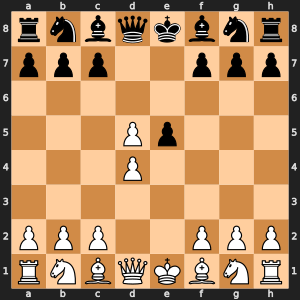

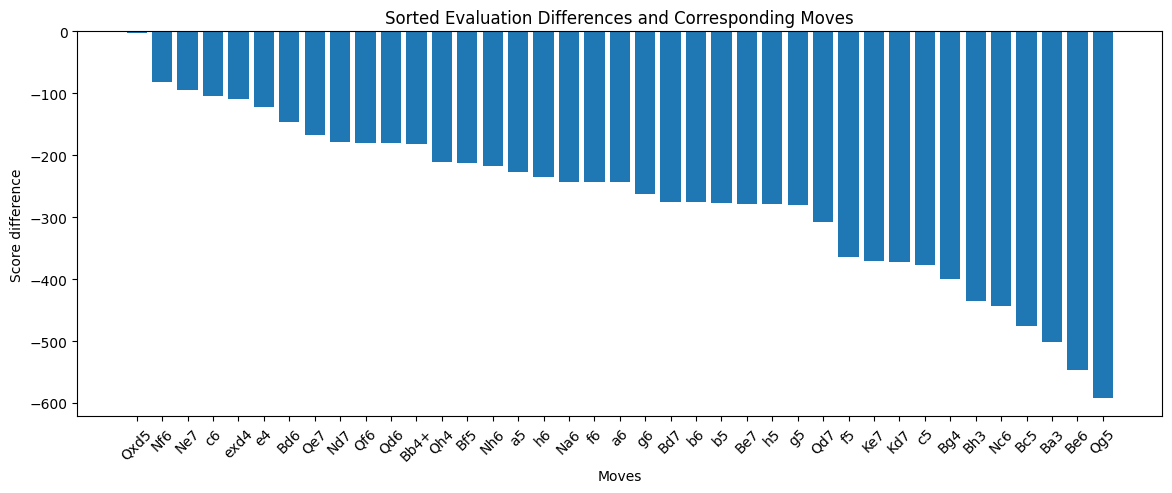

Worst move: Qg5 score difference: -592
Best move: Qxd5 score difference: -3
Mean difference score: -269.2307692307692
-----------------------------------------------------------------------------------
GPT-2 results:
  - Legal moves made: 40 / 200
  - Number of times the worst move was made: 0
  - Number of times the best move was made: 0
  - Number of times an above average move was made: 24


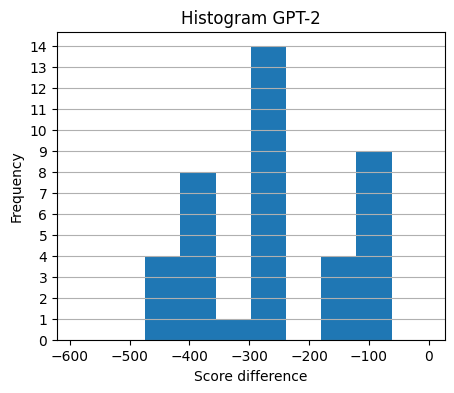

-----------------------------------------------------------------------------------
Random results:
  - Number of times the worst move was made: 1
  - Number of times the best move was made: 1
  - Number of times an above average move was made: 25


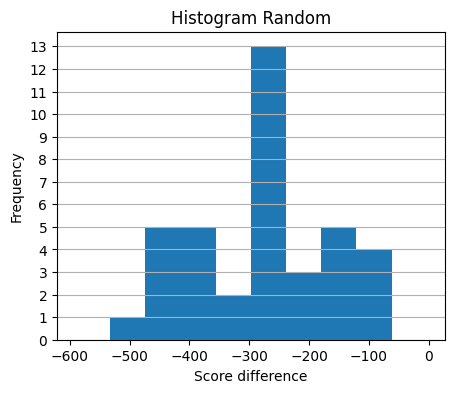

-----------------------------------------------------------------------------------
Player move score difference: -113
Game 1 | Number of moves: 5 | Evaluated answers: 200


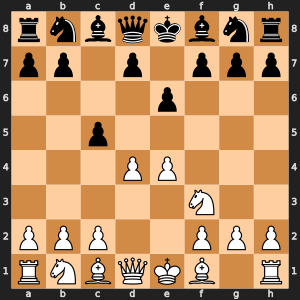

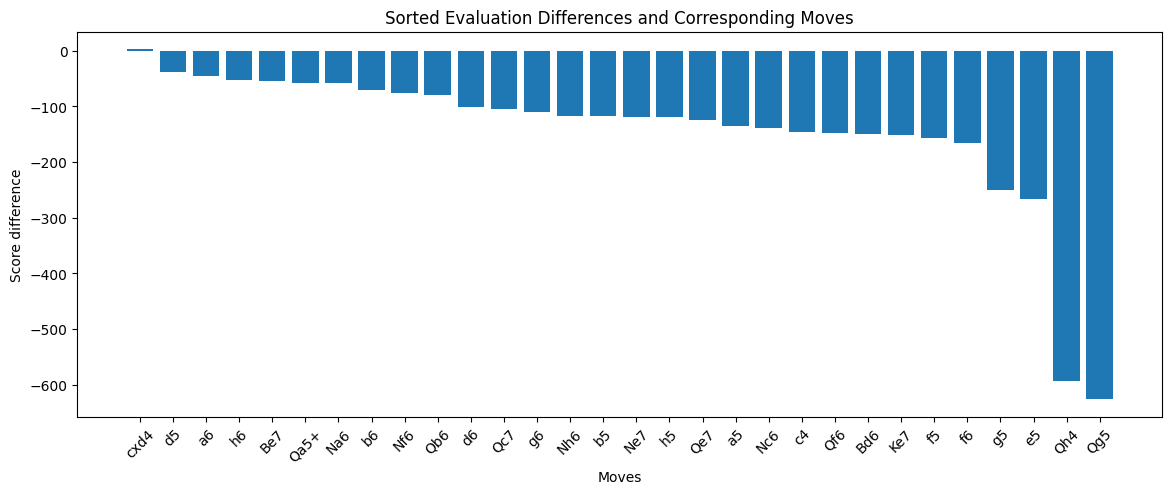

Worst move: Qg5 score difference: -626
Best move: cxd4 score difference: 3
Mean difference score: -145.7
-----------------------------------------------------------------------------------
GPT-2 results:
  - Legal moves made: 89 / 200
  - Number of times the worst move was made: 0
  - Number of times the best move was made: 14
  - Number of times an above average move was made: 70


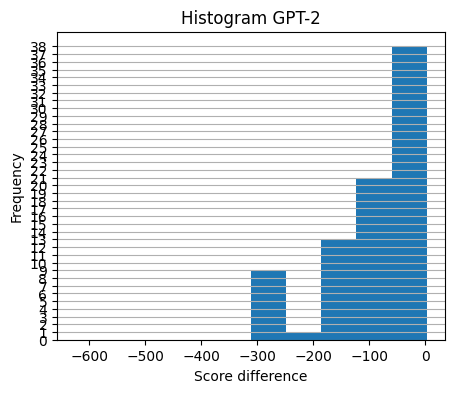

-----------------------------------------------------------------------------------
Random results:
  - Number of times the worst move was made: 1
  - Number of times the best move was made: 3
  - Number of times an above average move was made: 61


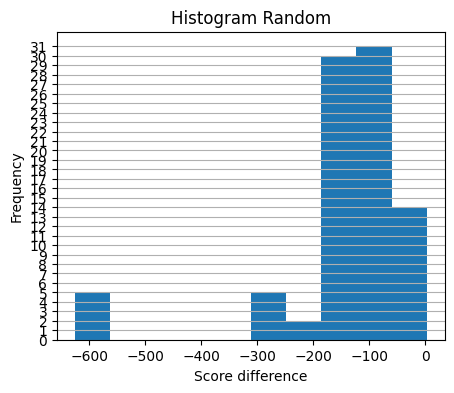

-----------------------------------------------------------------------------------
Player move score difference: -31


In [12]:
num_games = 2
transcripts = test_data_moves["transcript"][:num_games]
summary_gpt, summary_random, summary_player = \
    run_single_game_eval(transcripts, 5, 200, stockfish, generator, tokenizer,
                         print_conclusions=True, show_plots=True)

In [13]:
num_games = 20
transcripts = test_data_moves["transcript"][:num_games]

num_answers = 200
tests_num_moves: List[int] = [5, 10, 15, 20]

player_dict: Dict[str, Any] = {"gpt": None, "random": None, "player": None}
summaries: Dict[int, Dict[str, Any]] = \
    dict((x, deepcopy(player_dict)) for x in tests_num_moves)
player_avg_diff_scores: List[float] = []

for num_moves in tests_num_moves:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Testing results after {num_moves} moves")
    summary_gpt, summary_random, summary_player = \
        run_single_game_eval(transcripts, num_moves, num_answers,
                             stockfish, generator, tokenizer)
    summaries[num_moves]["gpt"] = summary_gpt
    summaries[num_moves]["random"] = summary_random
    summaries[num_moves]["player"] = summary_player

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 5 moves


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 10 moves
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 15 moves
15 is too many moves for game 1, skipping...
15 is too many moves for game 5, skipping...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 20 moves
20 is too many moves for game 1, skipping...
20 is too many moves for game 5, skipping...


Number of moves before evaluation: 5
---------------------------------------
GPT-2:
 - Average score difference after move: -88.87815501996161
 - Total number of legal moves: 1221 / 4000
 - Total number of best moves: 103 / 1221
 - Total number of worst moves: 11 / 1221
 - Total number of above average moves: 1051 / 1221


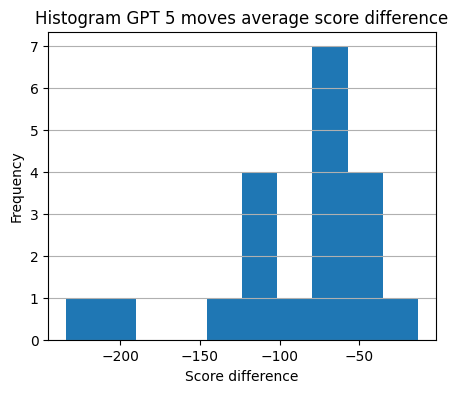

---------------------------------------
Random:
 - Average score difference after move: -138.15796229728602
 - Total number of best moves: 47 / 1221
 - Total number of worst moves: 37 / 1221
 - Total number of above average moves: 899 / 1221


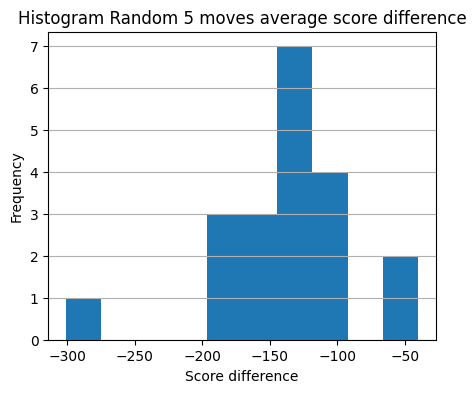

---------------------------------------
Player:
 - Average score difference after move: -29.0
 - Total number of best moves: 4 / 20
 - Total number of worst moves: 0 / 20
 - Total number of above average moves: 19 / 20
Number of moves before evaluation: 10
---------------------------------------
GPT-2:
 - Average score difference after move: -203.0668656348492
 - Total number of legal moves: 1025 / 4000
 - Total number of best moves: 75 / 1025
 - Total number of worst moves: 10 / 1025
 - Total number of above average moves: 755 / 1025


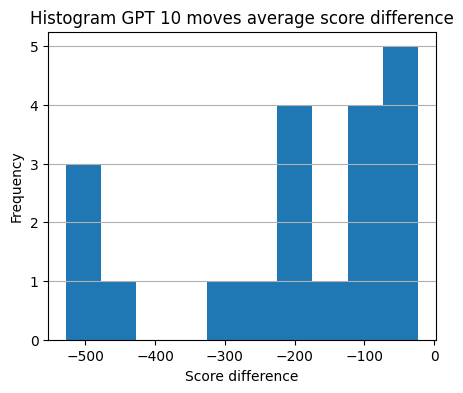

---------------------------------------
Random:
 - Average score difference after move: -265.0614161850224
 - Total number of best moves: 29 / 1025
 - Total number of worst moves: 24 / 1025
 - Total number of above average moves: 629 / 1025


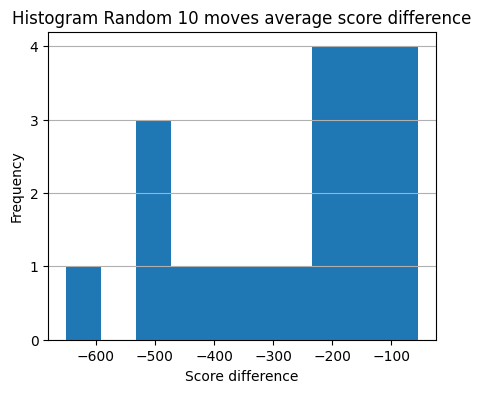

---------------------------------------
Player:
 - Average score difference after move: -72.55
 - Total number of best moves: 3 / 20
 - Total number of worst moves: 0 / 20
 - Total number of above average moves: 19 / 20
Number of moves before evaluation: 15
---------------------------------------
GPT-2:
 - Average score difference after move: -242.67404221102456
 - Total number of legal moves: 665 / 3600
 - Total number of best moves: 37 / 665
 - Total number of worst moves: 9 / 665
 - Total number of above average moves: 418 / 665


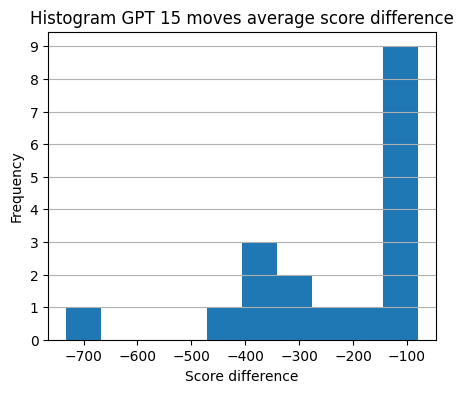

---------------------------------------
Random:
 - Average score difference after move: -270.48770315760953
 - Total number of best moves: 14 / 665
 - Total number of worst moves: 20 / 665
 - Total number of above average moves: 378 / 665


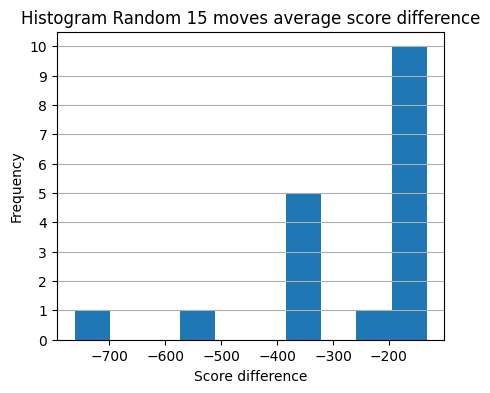

---------------------------------------
Player:
 - Average score difference after move: -77.66666666666667
 - Total number of best moves: 7 / 18
 - Total number of worst moves: 0 / 18
 - Total number of above average moves: 17 / 18
Number of moves before evaluation: 20
---------------------------------------
GPT-2:
 - Average score difference after move: -323.54633116936634
 - Total number of legal moves: 550 / 3600
 - Total number of best moves: 19 / 550
 - Total number of worst moves: 8 / 550
 - Total number of above average moves: 295 / 550


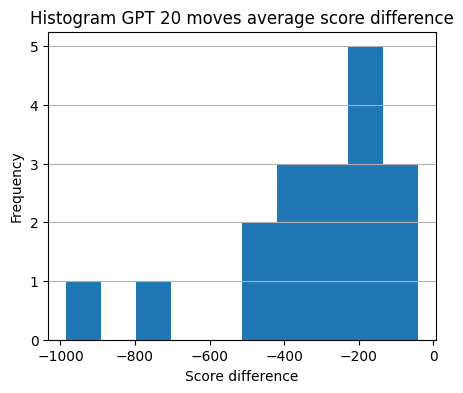

---------------------------------------
Random:
 - Average score difference after move: -365.8909172182861
 - Total number of best moves: 17 / 550
 - Total number of worst moves: 23 / 550
 - Total number of above average moves: 262 / 550


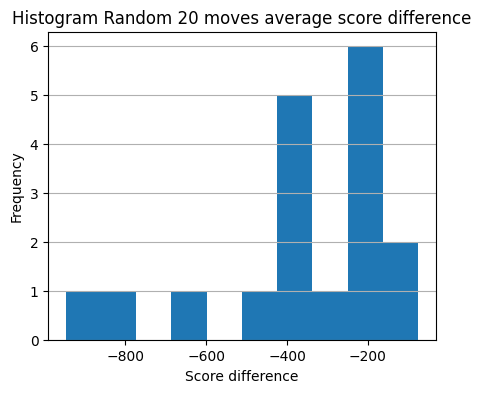

---------------------------------------
Player:
 - Average score difference after move: -92.38888888888889
 - Total number of best moves: 3 / 18
 - Total number of worst moves: 0 / 18
 - Total number of above average moves: 16 / 18

Aggregate results GPT-2
 - Average score difference after move: -214.54134850880044
 - Total number of legal moves: 3461 / 15200
 - Total number of best moves: 234 / 3461
 - Total number of worst moves: 38 / 3461
 - Total number of above average moves: 2519 / 3461
----------------------------------------------------------------
Aggregate results Random
 - Average score difference after move: -259.89949971455104
 - Total number of best moves: 107 / 3461
 - Total number of worst moves: 104 / 3461
 - Total number of above average moves: 2168 / 3461
----------------------------------------------------------------
Aggregate results Player
 - Average score difference after move: -67.90138888888889
 - Total number of best moves: 17 / 76
 - Total number of worst mo

In [14]:
show_results_single_eval(summaries, tests_num_moves)

#### Test 2: same tests but try to force legal moves

Issues: 
- Every elemnt of a move is treated as separate tokens, random combinations of these tokens at output.
- Since we cannot set ```do_sample=True``` in this scenario (prohibited with forced words), generate one output for more games.

In [15]:
class AlternativesPipeline(TextGenerationPipeline):
    """
    Custom pipeline for generating text with
    forced inclusion of specified words.
    """
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)

    def __call__(self, *args: Any,
                 force_words: Optional[List[str]] = None,
                 **kwargs: Any) -> Any:
        """
        Override the call method to include forced
        words in the text generation.

        Args:
            force_words (Optional[List[str]]): List of
            words to force include in the generation.

        Returns:
            Any: The generated text with forced words.
        """

        force_words_ids = [
            self.tokenizer(force_words,
                           add_special_tokens=False).input_ids
        ]

        kwargs["force_words_ids"] = force_words_ids
        return super().__call__(*args, **kwargs)

gpt_h = GPT2LMHeadModel.from_pretrained("gpt2",
                                        no_repeat_ngram_size=1,
                                        remove_invalid_values=True).to("cuda")

forced_generator = AlternativesPipeline(
    model=gpt_h,
    tokenizer=GPT2Tokenizer.from_pretrained("gpt2"),
    device=0
)

model_config = forced_generator.model.config
print(f"""
{model_config.num_beams, model_config.num_beam_groups}
{model_config.do_sample}
{model_config.top_p, model_config.top_k}
{model_config.max_length, model_config.no_repeat_ngram_size}
{model_config.remove_invalid_values}
{model_config.num_return_sequences}
""")


(1, 1, False)
(1.0, 50)
(20, 1, True)
1



In [16]:
alternatives = ["dog"]

print(forced_generator("What is your favorite animal? A:",
                       max_length=25,
                       truncation=True,
                       pad_token_id=forced_generator.tokenizer.eos_token_id,
                       force_words=alternatives,
                       num_return_sequences=1,
                       num_beams=10)[0]["generated_text"])

What is your favorite animal? A: Well, I'm a big fan of dogs and cats. They're my petdog


In [17]:
num_moves_list = [5, 10, 15, 20]
transcripts = test_data_moves["transcript"][:50]
summaries = run_legal_forced_test(transcripts, num_moves_list,
                                  stockfish, generator, forced_generator)

Tests for 5 moves


 84%|████████▍ | 42/50 [01:27<00:16,  2.02s/it]

5 is too many moves for game 42, skipping...


100%|██████████| 50/50 [01:41<00:00,  2.02s/it]


Tests for 10 moves


 84%|████████▍ | 42/50 [01:41<00:17,  2.22s/it]

10 is too many moves for game 42, skipping...


100%|██████████| 50/50 [01:57<00:00,  2.36s/it]


Tests for 15 moves


  2%|▏         | 1/50 [00:01<01:24,  1.73s/it]

15 is too many moves for game 1, skipping...


 10%|█         | 5/50 [00:07<01:14,  1.66s/it]

15 is too many moves for game 5, skipping...


 42%|████▏     | 21/50 [00:44<01:14,  2.57s/it]

15 is too many moves for game 21, skipping...


 84%|████████▍ | 42/50 [01:30<00:19,  2.44s/it]

15 is too many moves for game 42, skipping...


100%|██████████| 50/50 [01:45<00:00,  2.12s/it]


Tests for 20 moves


  2%|▏         | 1/50 [00:02<02:20,  2.86s/it]

20 is too many moves for game 1, skipping...


 10%|█         | 5/50 [00:10<01:32,  2.06s/it]

20 is too many moves for game 5, skipping...


 42%|████▏     | 21/50 [00:45<01:15,  2.60s/it]

20 is too many moves for game 21, skipping...


 70%|███████   | 35/50 [01:15<00:35,  2.40s/it]

20 is too many moves for game 35, skipping...


 84%|████████▍ | 42/50 [01:31<00:18,  2.34s/it]

20 is too many moves for game 42, skipping...
20 is too many moves for game 43, skipping...


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


Number of moves before evaluation: 5
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Average score difference after move: -47.35294117647059
 - Total number of legal moves: 17 / 49
 - Total number of best moves: 2 / 17
 - Total number of worst moves: 0 / 17
 - Total number of above average moves: 16 / 17


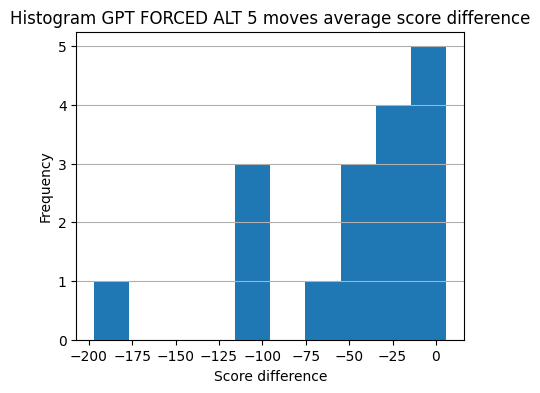

---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -83.5625
 - Total number of legal moves: 16 / 49
 - Total number of best moves: 0 / 16
 - Total number of worst moves: 0 / 16
 - Total number of above average moves: 14 / 16


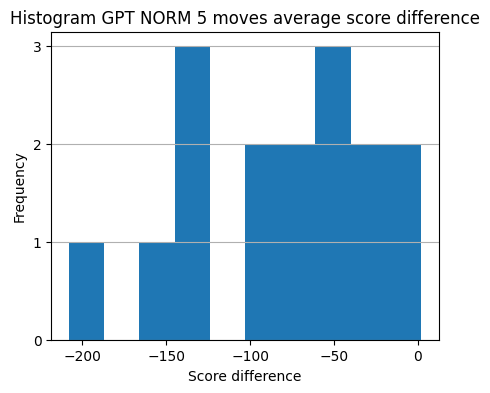

---------------------------------------
Random:
 - Average score difference after move: -157.23529411764707
 - Total number of best moves: 0 / 17
 - Total number of worst moves: 1 / 17
 - Total number of above average moves: 13 / 17


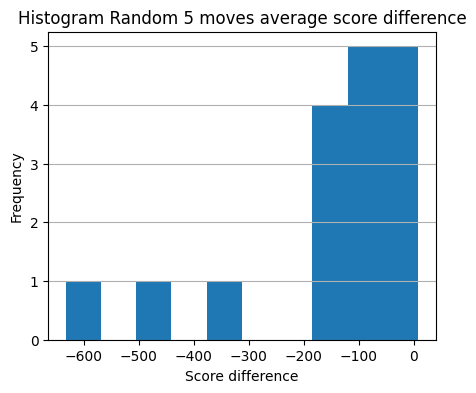

---------------------------------------
Player:
 - Average score difference after move: -18.235294117647058
 - Total number of best moves: 5 / 17
 - Total number of worst moves: 0 / 17
 - Total number of above average moves: 17 / 17


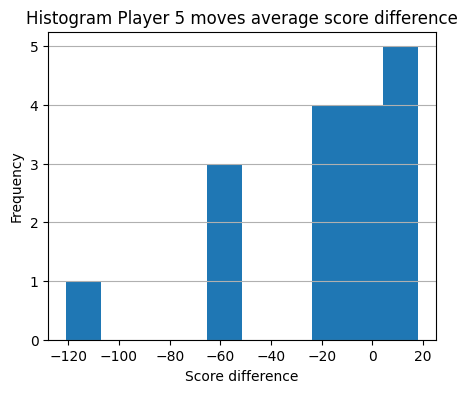

Number of moves before evaluation: 10
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Total number of legal moves: 0 / 49
 - Total number of best moves: 0 / 0
 - Total number of worst moves: 0 / 0
 - Total number of above average moves: 0 / 0
No correct moves
---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -90.83333333333333
 - Total number of legal moves: 6 / 49
 - Total number of best moves: 0 / 6
 - Total number of worst moves: 0 / 6
 - Total number of above average moves: 6 / 6


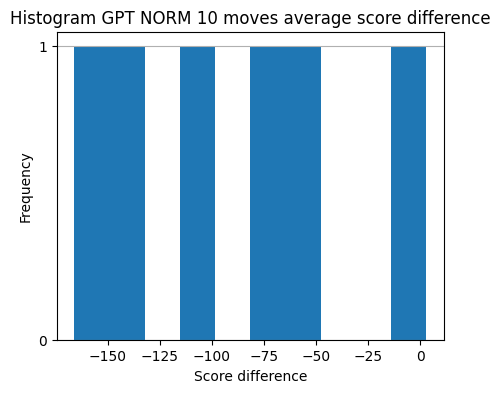

No correct forced model moves, no random comparison
No correct forced model moves, no player comparison
Number of moves before evaluation: 15
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Average score difference after move: -134.45454545454547
 - Total number of legal moves: 11 / 46
 - Total number of best moves: 0 / 11
 - Total number of worst moves: 0 / 11
 - Total number of above average moves: 10 / 11


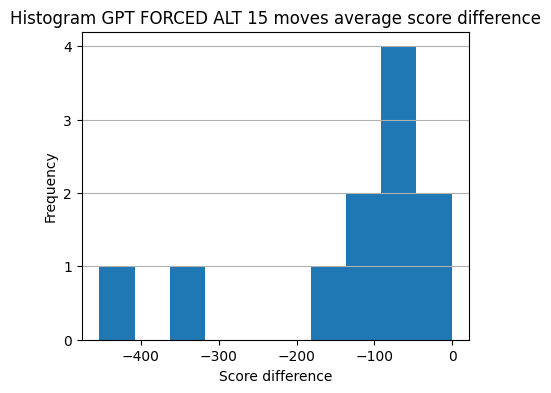

---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -191.54545454545453
 - Total number of legal moves: 11 / 46
 - Total number of best moves: 1 / 11
 - Total number of worst moves: 0 / 11
 - Total number of above average moves: 9 / 11


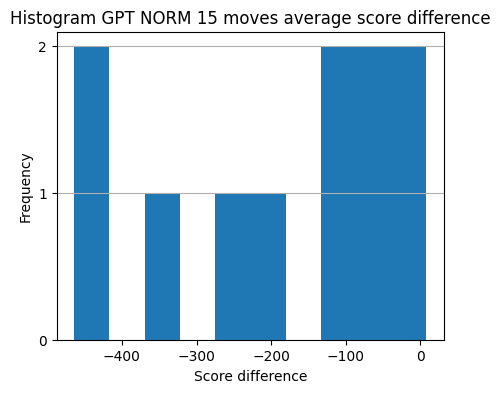

---------------------------------------
Random:
 - Average score difference after move: -192.54545454545453
 - Total number of best moves: 0 / 11
 - Total number of worst moves: 1 / 11
 - Total number of above average moves: 9 / 11


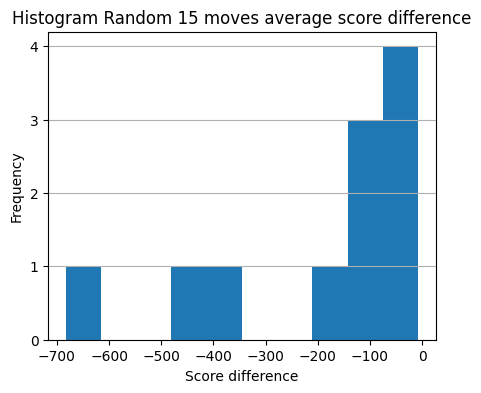

---------------------------------------
Player:
 - Average score difference after move: -59.09090909090909
 - Total number of best moves: 2 / 11
 - Total number of worst moves: 0 / 11
 - Total number of above average moves: 11 / 11


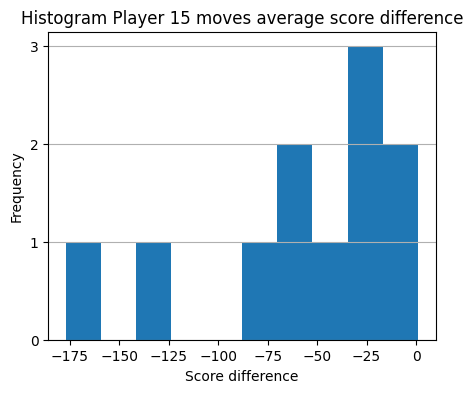

Number of moves before evaluation: 20
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Average score difference after move: -59.5
 - Total number of legal moves: 2 / 44
 - Total number of best moves: 0 / 2
 - Total number of worst moves: 0 / 2
 - Total number of above average moves: 2 / 2


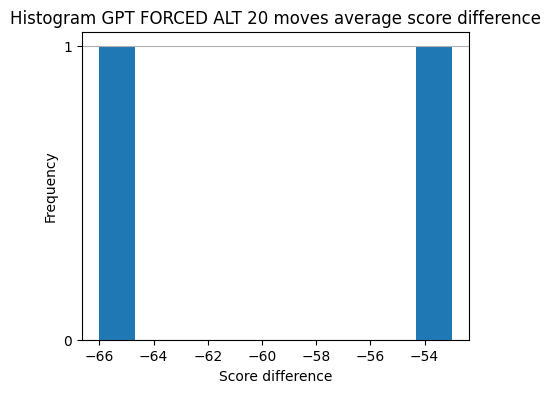

---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -263.14285714285717
 - Total number of legal moves: 7 / 44
 - Total number of best moves: 0 / 7
 - Total number of worst moves: 0 / 7
 - Total number of above average moves: 5 / 7


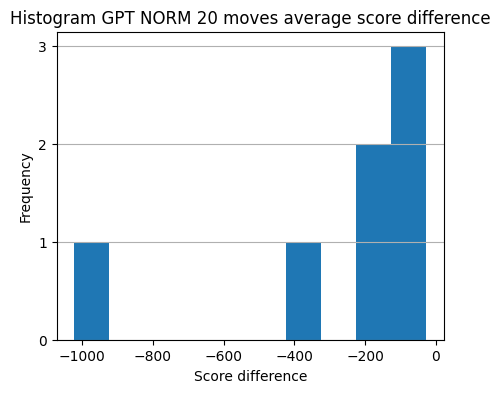

---------------------------------------
Random:
 - Average score difference after move: -75.0
 - Total number of best moves: 0 / 2
 - Total number of worst moves: 0 / 2
 - Total number of above average moves: 2 / 2


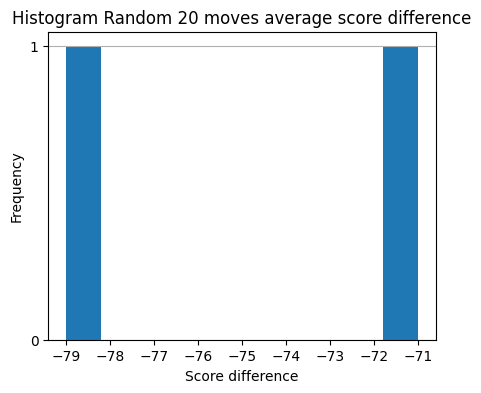

---------------------------------------
Player:
 - Average score difference after move: -105.5
 - Total number of best moves: 0 / 2
 - Total number of worst moves: 0 / 2
 - Total number of above average moves: 1 / 2


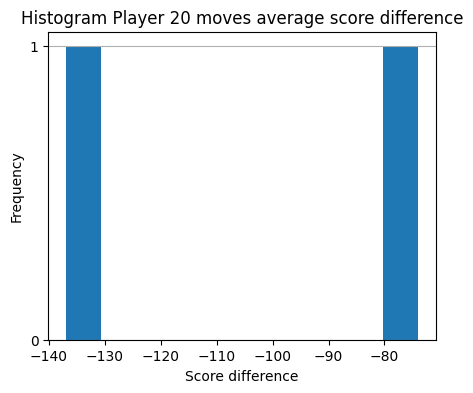

Aggregate results GPT-2 FORCED ALTERNATIVES
 - Average score difference after move: -80.436
 - Total number of legal moves: 30 / 188
 - Total number of best moves: 2 / 30
 - Total number of worst moves: 0 / 30
 - Total number of above average moves: 28 / 30
----------------------------------------------------------------
Aggregate results GPT-2 NORMAL
 - Average score difference after move: -157.271
 - Total number of legal moves: 40 / 188
 - Total number of best moves: 1 / 40
 - Total number of worst moves: 0 / 40
 - Total number of above average moves: 34 / 40
----------------------------------------------------------------
Aggregate results Random
 - Average score difference after move: -141.594
 - Total number of best moves: 0 / 30
 - Total number of worst moves: 2 / 30
 - Total number of above average moves: 24 / 30
----------------------------------------------------------------
Aggregate results Player
 - Average score difference after move: -60.942
 - Total number of best moves

In [18]:
show_results_forced_test(summaries, num_moves_list)